Data loaded successfully. Sample:
   engine_id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0          1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29   
1          1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45   
2          1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94   
3          1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12   
4          1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19   

        s4     s5  ...     s12      s13      s14     s15   s16  s17   s18  \
0  1398.21  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388   
1  1395.42  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388   
2  1401.34  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388   
3  1406.42  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388   
4  1401.92  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388   

     s19    s20      s21  
0  100.

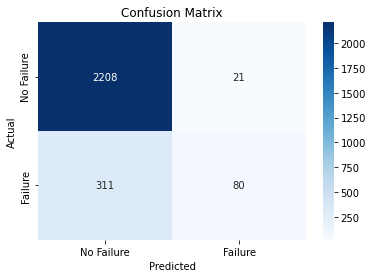

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ---------------------------
# Step 1. Load and Inspect the Data
# ---------------------------
# The PM_test.txt file is expected to have 26 columns with no header.
# Based on typical turbofan datasets, we label the columns as follows:
# 1. engine_id, 2. cycle, 3-5: operational settings, 6-26: sensor measurements.
data_file = "PM_test.txt"  # Update the path if necessary

# Define column names
cols = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3']
sensor_cols = [f's{i}' for i in range(1, 22)]  # s1 to s21
cols.extend(sensor_cols)

# Load the data (assuming whitespace-separated values)
try:
    df = pd.read_csv(data_file, delim_whitespace=True, header=None, names=cols)
    print("Data loaded successfully. Sample:")
    print(df.head())
except Exception as e:
    print(f"Error loading the file {data_file}: {e}")
    raise SystemExit

# ---------------------------
# Step 2. Compute Remaining Useful Life (RUL) and Create a Target
# ---------------------------
# For each engine, assume the final cycle marks failure.
# Compute RUL: the difference between the maximum cycle for the engine and the current cycle.
max_cycle_per_engine = df.groupby('engine_id')['cycle'].max().rename('max_cycle')
df = df.merge(max_cycle_per_engine, on='engine_id')
df['RUL'] = df['max_cycle'] - df['cycle']

# Define a threshold for "failure imminent." Here, if RUL < 20, flag failure = 1; otherwise 0.
threshold = 20
df['failure'] = (df['RUL'] < threshold).astype(int)

print("\nSample data with RUL and failure flag:")
print(df[['engine_id', 'cycle', 'RUL', 'failure']].head(10))

# ---------------------------
# Step 3. Feature Selection and Data Splitting
# ---------------------------
# Use the operational settings and sensor measurements as features.
features = ['setting1', 'setting2', 'setting3'] + sensor_cols
X = df[features]
y = df['failure']

# Random split: note that for time series data you may need to split by engine or time.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# ---------------------------
# Step 4. Feature Scaling
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# Step 5. Model Training
# ---------------------------
# Train a RandomForestClassifier as a baseline for predicting failure imminence.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# ---------------------------
# Step 6. Model Evaluation
# ---------------------------
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure Imminent", "Failure Imminent"]))

# Plot a confusion matrix to visualize performance.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=["No Failure", "Failure"],
            yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
